#  Прогнозирование заказов такси

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

<img src='https://cdn.fishki.net/upload/post/201412/19/1356488/1_shutterstock_46711102-nieuw.jpg'>

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, необходимо спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# загрузим все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
# напишем функцию для вычисления метрики rmse
def rmse_score(target, predictions):
    return mean_squared_error(target, predictions)**.5

Загрузим данные в датафрейм **taxi**. В параметрах метода **read_csv** укажем столбец `'datetime'` в качестве даты-индекса.

In [3]:
taxi = pd.read_csv('C:\\Users\\503so\\OneDrive\\Desktop\\praktikum-to-git\\12_taxi.csv', index_col=['datetime'], parse_dates=['datetime'])

Выведем на экран первые 5 строк датафрейма, а также информацию о нем.

In [4]:
display(taxi.head())
print(taxi.info())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


Видим, что наш датасет содержит 26496 строк временного ряда, при этом шаг составляет 10 минут.


Выполним ресемплирование по 1 часу.

In [5]:
taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()

In [6]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


Проверим, корректно ли было произведено ресемплирование. Поскольку шаг исходного временного ряда составляет 10 минут, а итогового - 1 час, и в 1 часе 6 раз по 10 минут, размер полученного датасета должен быть в 6 раз меньше, чем исходного.

In [7]:
26496 / 6

4416.0

Ресемплирование выполненно корректно.

Посмотрим на первые 5 строк полученного датафрейма.

In [8]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

Посмотрим на среднее и медианное количество заказов такси в час.

In [9]:
print('В среднем за час', taxi['num_orders'].mean(), 'раз заказывают такси.')
print('Медианное количество заказов такси в час составляет', taxi['num_orders'].median())

В среднем за час 84.42278079710145 раз заказывают такси.
Медианное количество заказов такси в час составляет 78.0


Добавим к датасету столбец `'rolling_mean'`, в котором сохраним скользящее среднее значение количества заказов с окном, равным 18.

In [10]:
taxi['rolling_mean'] = taxi.rolling(18).mean()

In [11]:
# избавимся от образовавшихся пропусков
taxi = taxi.dropna()

Построим график временного ряда со скользящим средним для всего диапазона данных.

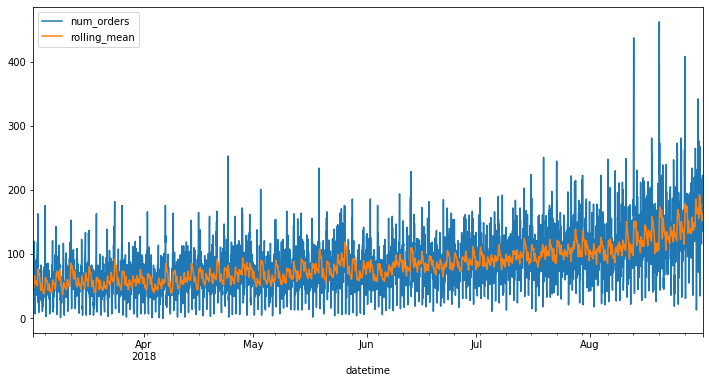

In [12]:
taxi.plot(figsize=(12,6))
plt.show()

Для интервала в один месяц с 1 по 31 мая.

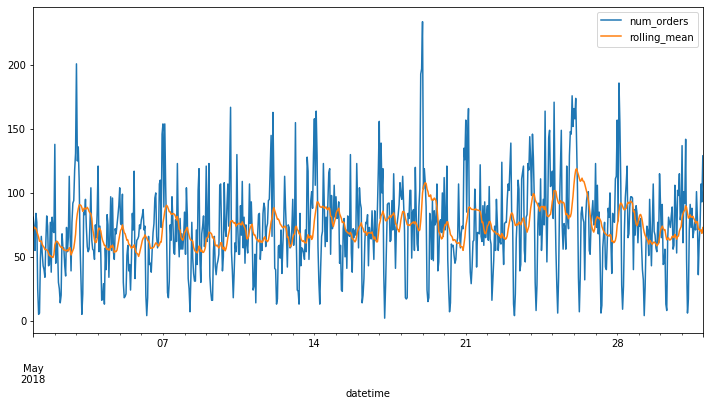

In [13]:
taxi['2018-05-01':'2018-05-31'].plot(figsize=(12,6))
plt.show()

Для интервала в 1 неделю с 1 по 7 мая.

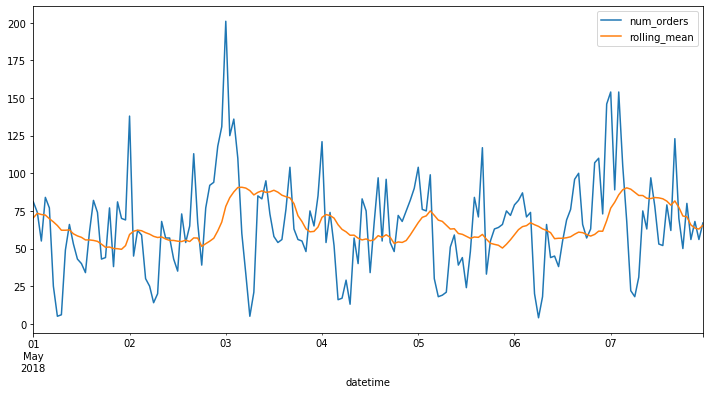

In [14]:
taxi['2018-05-01':'2018-05-07'].plot(figsize=(12,6))
plt.show()

И за сутки с 00:00:00 до 23:59:59 15 мая.

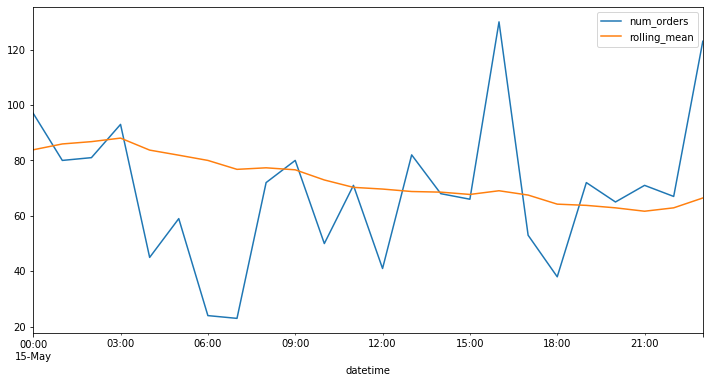

In [15]:
taxi['2018-05-15 00:00:00':'2018-05-15 23:59:59'].plot(figsize=(12,6))
plt.show()

Наблюдается тренд на **увеличение** среднего количества заказов такси в час *с марта по август*.

Разложим временной ряд на 3 составляющие: **тренд, сезонную составляющую и остаток декомпозиции**. Построим графики для каждой из них.

In [16]:
decomposed = seasonal_decompose(taxi)

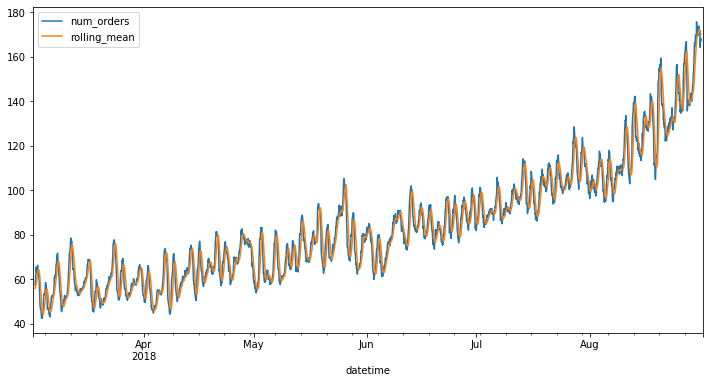

In [17]:
decomposed.trend.plot(ax=plt.gca(), figsize=(12,6))
plt.show()

Сезонность рассмотрим на небольшом интервале в 2 дня.

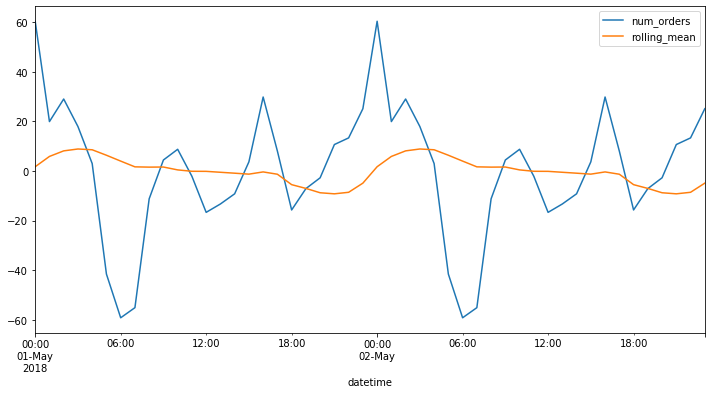

In [18]:
decomposed.seasonal['2018-05-01':'2018-05-02'].plot(ax=plt.gca(), figsize=(12,6))
plt.show()

Наблюдаем цикличность (сезонность), соответствующую 1 дню (24 часа), т.е. *внутрисуточную сезонность*. При этом наибольшие значения количества заказов такси относятся к полуночи, на втором месте - 17 часов, на 3 месте - 11 часов дня, и меньше всего заказов в 6 утра.

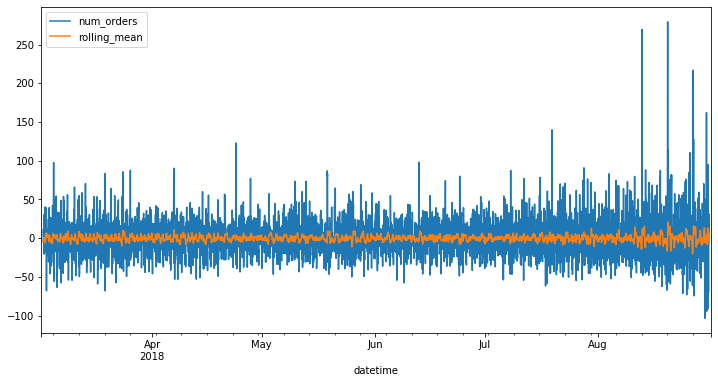

In [19]:
decomposed.resid.plot(ax=plt.gca(), figsize=(12,6))
plt.show()

Добавим  столбец `'std'`, содержащий  стандартное отклонение со скользящим сглаживанием (величина окна равна 18).

In [21]:
taxi['std'] = taxi['num_orders'].rolling(18).std()

Построим график после всех преобразований.

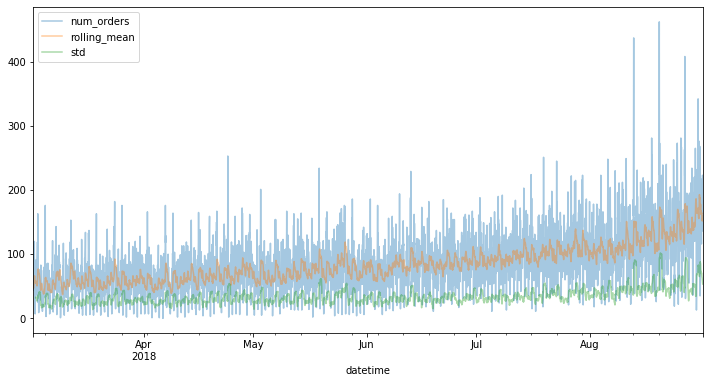

In [22]:
taxi.plot(figsize=(12, 6), alpha=.4)
plt.show()

## Обучение

Сперва создадим признаки: календарные признаки и отстающие значения.

In [23]:
taxi['dayofweek'] = taxi.index.dayofweek
taxi['hour'] = taxi.index.hour
taxi['lag_1'] = taxi['num_orders'].shift(1)
taxi['lag_2'] = taxi['num_orders'].shift(2)
taxi['lag_3'] = taxi['num_orders'].shift(3)

In [24]:
# удалим образовавшиеся пропуски
taxi = taxi.dropna()

И взглянем на первые 5 строк полученного датасета.

In [25]:
taxi.head()

,num_orders,rolling_mean,std,dayofweek,hour,lag_1,lag_2,lag_3
datetime,,,,,,,,
2018-03-02 10:00:00,54,55.722222,32.157344,4,10,45.0,46.0,7.0
2018-03-02 11:00:00,91,58.333333,33.045423,4,11,54.0,45.0,46.0
2018-03-02 12:00:00,36,56.277778,33.229692,4,12,91.0,54.0,45.0
2018-03-02 13:00:00,45,56.277778,33.229692,4,13,36.0,91.0,54.0
2018-03-02 14:00:00,44,55.333333,33.329019,4,14,45.0,36.0,91.0


Перейдем к подготовке выборок для обучения моделей.
Сперва разделим временной ряд на обучающую и тестовую выборки в соотношении 9:1.

In [26]:
train, test = train_test_split(taxi, shuffle=False, test_size=.1, random_state=503350)

Выделим обучающие признаки и целевой признак.

In [27]:
train_features = train.drop('num_orders', axis=1)
test_features = test.drop('num_orders', axis=1)
train_target = train['num_orders']
test_target = test['num_orders']

Проверим размерности полученных выборок.

In [28]:
print(train_features.shape)
print(test_features.shape)
print(train_target.shape)
print(test_target.shape)

(3943, 7)
(439, 7)
(3943,)
(439,)


## Тестирование

Обучим на полученных выборках *линейную регрессию и случайный лес* с подбором параметров на метрике **rmse_score**.


(*значение метрики не должно превышать 48*)

In [29]:
model = LinearRegression()
model.fit(train_features, train_target)
predictions_test = model.predict(test_features)
result_test = rmse_score(test_target, predictions_test)
predictions_train = model.predict(train_features)
result_train = rmse_score(train_target, predictions_train)

print('Значение метрики  RMSE на обучающей выборке:', result_train)
print('Значение метрики  RMSE на тестовой выборке:', result_test)

Значение метрики  RMSE на обучающей выборке: 30.382741412197294
Значение метрики  RMSE на тестовой выборке: 49.83242604293157


In [30]:
%%time
best_result = 48
for n_est in range(10, 100, 10):
    for depth in range (3, 13):
        forest_model = RandomForestRegressor(n_estimators = n_est,
                                             max_depth = depth,
                                             random_state=503350)
        forest_model.fit(train_features, train_target)
        for_predict = forest_model.predict(test_features)
        result = rmse_score(test_target, for_predict)
        if result < best_result:
            best_result = result
            best_est = n_est
            best_depth = depth
            
print('Значение метрики  RMSE на тестовой выборке:', best_result)
print('Оптимальное количество наблюдателей:', best_est)
print('Оптимальная глубина дерева:', best_depth)

Значение метрики  RMSE на тестовой выборке: 39.47507781629374
Оптимальное количество наблюдателей: 60
Оптимальная глубина дерева: 12
CPU times: user 38 s, sys: 159 ms, total: 38.2 s
Wall time: 38.3 s


Построим для сравнения графики реальных значений целевого признака и предсказаний моделей линейной регрессии и случайного леса.

In [31]:
real_values = pd.Series(test_target)
prediction1 = pd.Series(for_predict, index=real_values.index, name = 'predictions_forest')
prediction2 = pd.Series(predictions_test, index=real_values.index, name = 'predictions_linear')

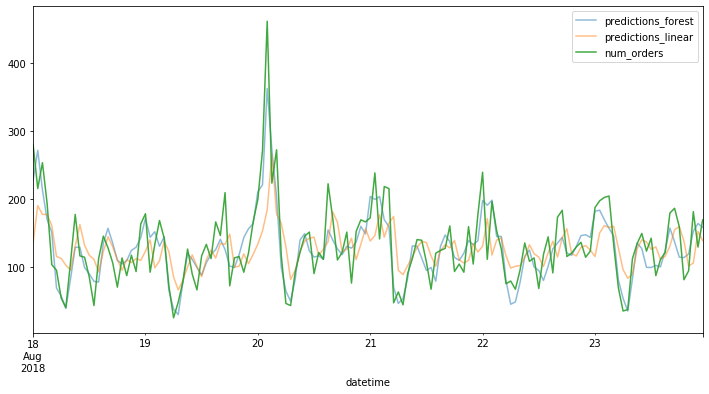

In [32]:
plt.figure(figsize=(12, 6))
prediction1['2018-08-18':'2018-08-23'].plot(alpha=.5)
prediction2['2018-08-18':'2018-08-23'].plot(alpha=.5)
real_values['2018-08-18':'2018-08-23'].plot(alpha=.9)
plt.legend()
plt.show()

## Вывод

С помощью модели линейной регрессии мы **не** получили точность предсказаний, удовлетворяющую заданию: **50 > 48**. Точность предсказаний дерева решений выше: ошибка меньше и  составляет **39.5**.
Ансамблевая модель предсказуемо показала результат, лучший, чем у простой модели линейной регрессии.

Тот же вывод можно сделать, проанализировав графики целевого признака и предсказаний моделей. Видно, что предсказания "сглаживают углы". Т.е. расхождение с реальными данными наблюдается на пиках, при этом на непрерывных участках графика предсказания либо соответствуют реальным значениям, либо очень близки к ним.